This notebook reproduces (and extends) the plots in
https://wandb.ai/data-frugal-learning/harmonic-learning/reports/Regularized-NN-harmonic-learning--VmlldzoxOTUzNTkx.

It generates paper-ready plots.

### Load libraries

In [32]:
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.apis.public
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import stylesheets, utils

### Load wandb data

In [33]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/harmonic-learning",
    filters={"tags": {"$in": ["cliff_v2"]}},
)

df_all = utils.runs_to_df(runs)
df = df_all[df_all.state == "finished"]
len(df)

276

In [3]:
hist = runs[0]._full_history(samples=10 ** 3)
print(len(hist))

# # Get minimum validation_mse for each run
# def get_min_val_mse(run: wandb.apis.public.Run, samples: int = 500,) -> float:
#     history = run.history(keys=["val_mse"], samples=samples)
#     return history.val_mse.min()

# df["min_val_mse"] = [get_min_val_mse(r) for r in tqdm(runs)]

1041


In [4]:
def get_min_val_mse_from_id(run_id: str, samples: int = 3 * 10 ** 4,) -> float:
    api = wandb.Api(timeout=30)
    run = api.run(f"data-frugal-learning/harmonic-learning/{run_id}")
    history = run.history(keys=["val_mse"], samples=samples)
    return history.val_mse.min()

df["min_val_mse"] = process_map(
    get_min_val_mse_from_id,
    [r.id for r in runs],
    max_workers=14,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
)

  0%|          | 0/276 [00:00<?, ?it/s]

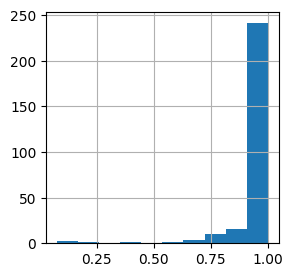

In [5]:
plt.figure(figsize=(3,3))
(df.min_val_mse / df.val_mse).hist();

In [27]:
x = (
    df.query("0.99 * val_mse <= min_val_mse & net_cfg_high_freq_freq_limit == 2")
    .sort_values("val_mse")
    .tail()
    .iloc[-1]
)
print(
    x.min_val_mse,
    x.val_mse,
    x.net_width,
    x.net_cfg_high_freq_freq_limit,
    x.n_train,
)


0.12229804694652557 0.12231335043907166 256 2 20


### Get pictures of trained network

In [29]:
START_ROW = df.query(
    "net_width == 512 & net_cfg_high_freq_freq_limit == 2 & n_train == n_train.min()"
).iloc[0]
print(
    START_ROW.net_width,
    START_ROW.net_cfg_high_freq_freq_limit,
    START_ROW.n_train,
    START_ROW.id,
)

BEST_ROW = df.query("final_val_mse == final_val_mse.min()").iloc[0]
print(
    BEST_ROW.net_width,
    BEST_ROW.net_cfg_high_freq_freq_limit,
    BEST_ROW.n_train,
    BEST_ROW.id,
)

512 2 5 1ht951jv
512 2 80 2qv0pjo5


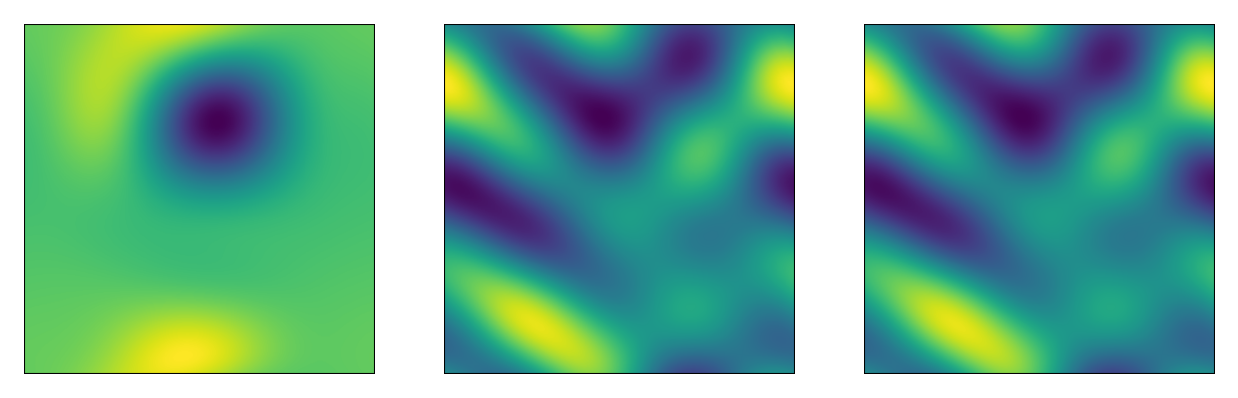

In [30]:
# Get start and best images from runs
plt.subplot(1, 3, 1)
start_img = utils.wandb_get_img(
    api.run(f"data-frugal-learning/harmonic-learning/{START_ROW.id}").file(
        START_ROW.trained_net_path
    )
).crop((143, 57, 514, 428))
plt.imshow(start_img)
plt.axis("off")

plt.subplot(1, 3, 2)
best_img = utils.wandb_get_img(
    api.run(f"data-frugal-learning/harmonic-learning/{BEST_ROW.id}").file(
        BEST_ROW.trained_net_path
    )
).crop((143, 57, 514, 428))
plt.imshow(best_img)
plt.axis("off")

plt.subplot(1, 3, 3)
true_img = utils.wandb_get_img(
    api.run(f"data-frugal-learning/harmonic-learning/{BEST_ROW.id}").file(
        BEST_ROW.true_hf_path
    )
).crop((143, 57, 514, 428))
plt.imshow(true_img)
plt.axis("off")

plt.show()

### Experimental plots

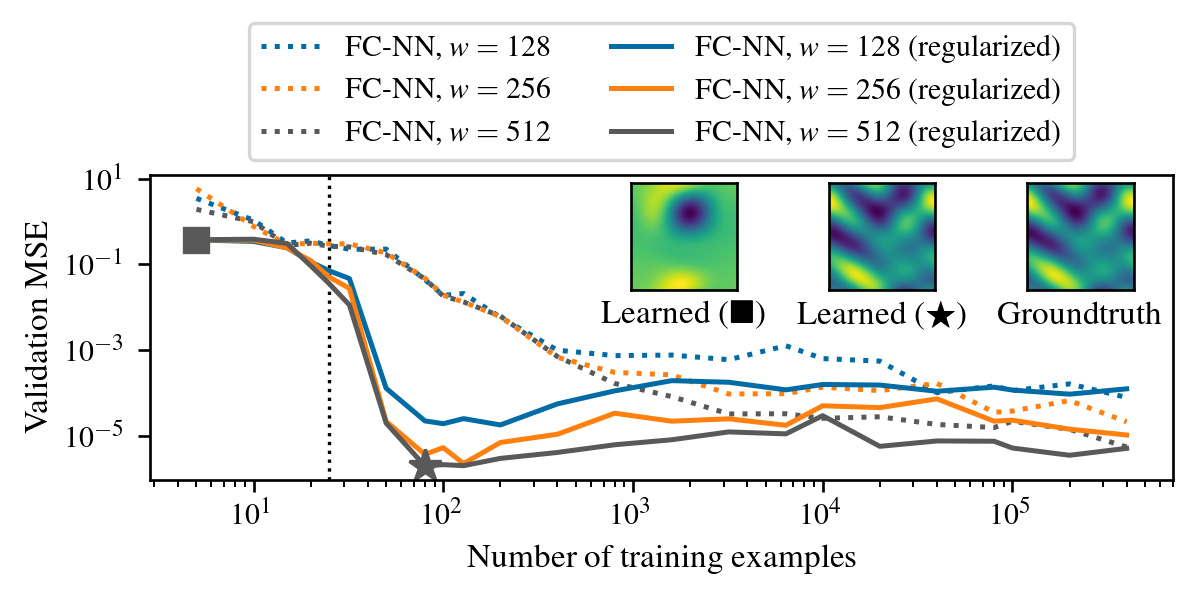

In [49]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
plt.style.use(
    [
        "tableau-colorblind10",
        stylesheets.ME_FOMO_2023["mplstyle"],
        {
            "pgf.preamble": "\n".join([r"\usepackage{amsmath,amssymb}"]),
        },
    ],
)
width = stylesheets.ME_FOMO_2023["col1_width"]
fig = plt.figure(figsize=(width, 0.3 * width))
target = "val_mse"

for w in [128, 256, 512]:
    cdf = (
        df.query("net_width == @w & net_cfg_high_freq_freq_limit == 0")
        .sort_values("n_train")
        .reset_index(drop=True)
    )
    if w == 512:
        # Cycle color forward by one, skipping light gray
        plt.plot([], [])
    plt.plot(
        cdf.n_train,
        cdf[target],
        label=rf"FC-NN, ${w=}$",
        linestyle=":",
        zorder=-1,
    )

# Reset color cycle
plt.gca().set_prop_cycle(None)
for w in [128, 256, 512]:
    cdf = (
        df.query("net_width == @w & net_cfg_high_freq_freq_limit == 2")
        .sort_values("n_train")
        .reset_index(drop=True)
    )
    if w == 512:
        # Cycle color forward by one, skipping light gray
        plt.plot([], [])
    ax = plt.plot(
        cdf.n_train,
        cdf[target],
        label=rf"FC-NN, ${w=}$ (regularized)",
    )

prev_color = ax[0].get_color()
plt.plot(
    START_ROW.n_train,
    START_ROW[target],
    "s",
    markersize=7,
    color=prev_color,
)
plt.plot(
    BEST_ROW.n_train,
    BEST_ROW[target],
    "*",
    markersize=10,
    color=prev_color,
)

plt.axvline(
    (2 * 2 + 1) ** 2,
    color="black",
    linestyle=":",
    zorder=-100,
    linewidth=1,
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel("Validation MSE")
# Legend on top
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)

# Plot start_img, best_img, true_img in top right corner
for i, img in enumerate([start_img, best_img, true_img]):
    newax = fig.add_axes(
        [0.31 + 0.15 * i, 0.59, 0.26, 0.27], anchor="NE", zorder=1
    )
    newax.imshow(img)
    # No ticks
    newax.set_xticks([])
    newax.set_yticks([])
    newax.set_xlabel([
        r"Learned ($\blacksquare$)",
        r"Learned ($\bigstar$)",
        r"Groundtruth"
    ][i])
    # Adjust xlabel slightly upwards
    newax.xaxis.set_label_coords(0.5, -0.1)

plt.savefig("figures/nn-harmonic-learning.pgf", bbox_inches="tight")

In [50]:
print(df.net_cfg_high_freq_mcls_samples.unique())
print(df.net_cfg_high_freq_lambda.unique())
print(df.batch_size.unique())
print(df.n_val.unique())

[20000]
[1]
[256]
[512]


Thoughts on above figure: Should we also include the learning-curve of an FFT-based algorithm? (I think not, because it doesn't add to the main point of the figure, which is that NNs are able to cliff.)